In [2]:
# Importing Libraries 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

import tensorflow as tf
import tensorflow_addons as tfa
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

import cv2
import os
import shutil
from random import sample

In [4]:
df = pd.read_csv("D:/ocular/full_df.csv")

In [5]:
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [31]:
#set path

train_dir = 'training'
validation_dir = 'validation'
test_dir = 'testing'

training_source_path = 'D:/ocular/ODIR-5K/ODIR-5K/Training Images/'
testing_source_path = 'D:/ocular/ODIR-5K/ODIR-5K/Testing Images/'

training_path = 'D:/ocular/ODIR-5K/ODIR-5K/Training Images/'
validation_path = 'D:/ocular/ODIR-5K/ODIR-5K/Testing Images/'
testing_path = 'D:/ocular/ODIR-5K/ODIR-5K/Testing Images/'

#### Image Processing - CLAHE

In [32]:
# define croping function with tensorflow resize

def crop_image(image_path):
  image_data = tf.keras.preprocessing.image.load_img(image_path)
  
  array = tf.keras.preprocessing.image.img_to_array(image_data)
  image = tf.image.resize(
                        array, [200,200], 
                        method='bilinear',
                        preserve_aspect_ratio=True,
                        antialias=False,
                        )
  return image

In [33]:
# define method for image resize, croping and image Contrast Limited Adaptive Histogram Equalization (CLAHE)

def image_resize(image_path, dim):
  img = cv2.imread(image_path)
  if img.shape[1] != img.shape[0]:
    x = img.shape[1]//2
    y = img.shape[0]//2
    x = x-y
    img = img[0:0+img.shape[0], x:x+img.shape[0]]
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def CLAHE(image_path, dim, clipLimit, tileGridSize):
  img = image_resize(image_path, dim)
  clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  
  l, a, b = cv2.split(lab) 
  l2 = clahe.apply(l) 
  lab = cv2.merge((l2,a,b)) 
  img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

(1, 133, 200, 3)

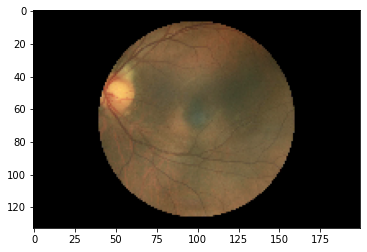

In [34]:
# before CLAHE processing

source = 'D:/ocular/ODIR-5K/ODIR-5K/Training Images/161_left.jpg'
test = crop_image(source)
test = np.array(test)
img = tf.keras.preprocessing.image.array_to_img(test)
plt.imshow(img)
test = np.expand_dims(test, axis=0)
test.shape

(1, 200, 200, 3)

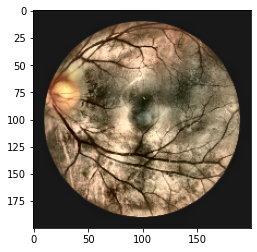

In [35]:
# showing CLAHE image Preprocessing

source = 'D:/ocular/ODIR-5K/ODIR-5K/Training Images/161_left.jpg'
test = CLAHE(source, (200,200), 20, (10,10))
test = np.array(test)
img = tf.keras.preprocessing.image.array_to_img(test)
plt.imshow(img)
test = test.reshape(1, 200, 200, 3)
test.shape

In [36]:
# set target size image

target_size = (230, 230)
color_mode = 'rgb'
if color_mode == 'grayscale':
  shapeadd = (1,)
if color_mode == 'rgb':
  shapeadd = (3,)

In [63]:
syntetic_labels = []
syntetic_features = []
image_array = []
processed_image_array = []
clahe_image = []
list_clahe = []
path = 'D:/ocular/ODIR-5K/ODIR-5K/Training Images/'
for i in range(len(df)):
  oneHotIndexLeft = []
  oneHotIndexRight = []
  for left_key in leftEyeKeywords[i]:
    oneHotIndexLeft.append(getIndexLabel(left_key, keyAll))
  for right_key in rightEyeKeywords[i]:
    oneHotIndexRight.append(getIndexLabel(right_key, keyAll))
  oneHotIndexLeft = list(set(oneHotIndexLeft))
  oneHotIndexRight = list(set(oneHotIndexRight))
  syntetic_labels.append(getMultiLabelFromKeys(oneHotIndexLeft))
  syntetic_labels.append(getMultiLabelFromKeys(oneHotIndexRight))
  syntetic_features.append(df['Left-Fundus'][i])
  syntetic_features.append(df['Right-Fundus'][i])
  clahe_image.append(CLAHE(path+df['Left-Fundus'][i], target_size, 20, (10,10)))
  clahe_image.append(CLAHE(path+df['Right-Fundus'][i], target_size, 20, (10,10)))

#### split feature, label, and file name for training, validation and test

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split

clahe_image = np.stack(clahe_image, axis=0)
syntetic_labels = np.asarray(syntetic_labels)

training_features, temp_validation_features, training_labels, temp_validation_labels, training_filenames, temp_validation_filenames = train_test_split(clahe_image, syntetic_labels, syntetic_features, test_size=0.102, random_state=1)

validation_features, test_features, validation_labels, test_labels, validation_filenames, test_filenames = train_test_split(temp_validation_features, temp_validation_labels, temp_validation_filenames, test_size=0.02, random_state=1)

print("training :", len(training_filenames))
print("validation :", len(validation_filenames))
print("test :", len(test_filenames))

# delete temporary list file for minimalizing memory usage

del clahe_image
del syntetic_labels
del temp_validation_features
del temp_validation_labels
del temp_validation_filenames

training : 6286
validation : 699
test : 15


#### show some image for training

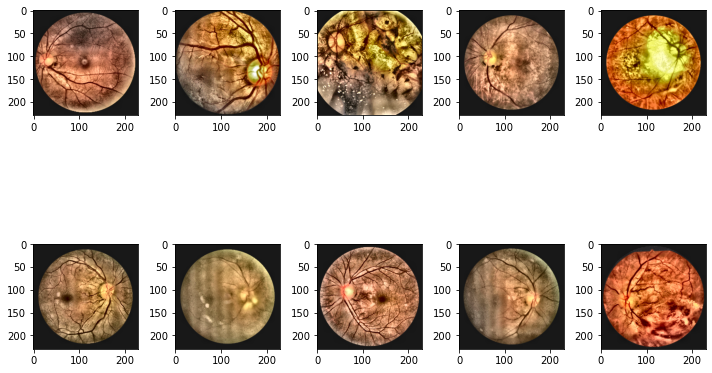

In [65]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        if color_mode == 'rgb':
          ax[i,j].imshow(training_features[k].reshape(target_size[0], target_size[1], 3) , cmap = "hsv")
        else :
          ax[i,j].imshow(training_features[k].reshape(target_size[0], target_size[1]) , cmap = "gray")
        k += 1
    plt.tight_layout()  

#### show some image for validation

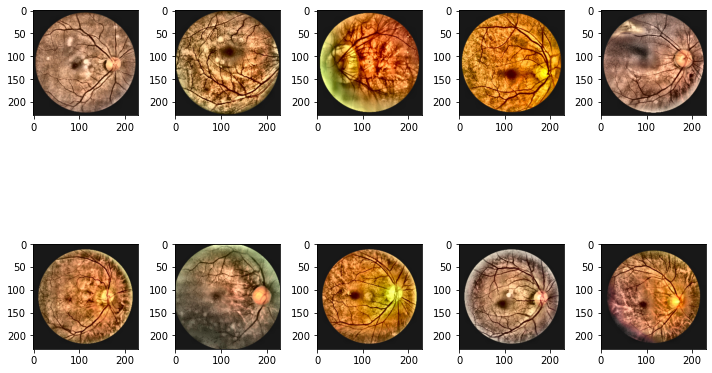

In [66]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(validation_features[k].reshape(target_size[0], target_size[1], 3) , cmap = "hsv")
        k += 1
    plt.tight_layout()  

#### set image data generator for training

In [68]:
train_datagen = ImageDataGenerator(
                                  rescale = 1./255,
                                  rotation_range=30,
                                  horizontal_flip=True,
                                  shear_range=0.2,
                                  zoom_range=0.2
                                  )


train_generator = train_datagen.flow(
                                    training_features, 
                                    y=training_labels, 
                                    batch_size=32
                                    )

validation_datagen = ImageDataGenerator(
                                        rescale = 1./255,
                                        )

validation_generator = validation_datagen.flow(
                                          validation_features, 
                                          y=validation_labels, 
                                          batch_size=32
                                          )

#### set metric for training

In [71]:
AUC_value = tf.keras.metrics.AUC(
                                  name='auc_value', 
                                  curve='ROC', 
                                  summation_method='interpolation',
                                  multi_label=True,
                                  )

kappa_score = tfa.metrics.CohenKappa(
                                      num_classes=8,
                                      name='kappa score',
                                    )

F1_score = tfa.metrics.F1Score(
                                num_classes=8,
                                name='F-1 score',
                                average='macro',
                                threshold=0.5,
                              )

#### Define Model

### VGG19

In [74]:
use_model = "using custom"

In [75]:
if ("use transfer learning" in use_model):

  if("using vgg19" in use_model):
    base_model= tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=target_size+shapeadd,)
    model_path = 'D:/ocular/ODIR-5K/ODIR-5K-VGG19-Multi-Label/'

  if("using mobilenetv2" in use_model):
    base_model= tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=target_size+shapeadd,)
    model_path = 'D:/ocular/ODIR-5K/ODIR-5K-MobileNetV2-Multi-Label/'

  for layer in base_model.layers:
    layer.trainable = False

  base_model.summary()

  conn = base_model.output

  conn = tf.keras.layers.Flatten()(conn)
  conn = tf.keras.layers.Dense(256, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  conn = tf.keras.layers.Dense(128, activation='relu', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              )(conn)

  conn = tf.keras.layers.Dropout(0.2)(conn)

  conn = tf.keras.layers.Dense(8, activation='sigmoid')(conn)

if (use_model == "using custom"):
  model_path = 'D:/ocular/ODIR-5K/ODIR-5K-VGG16_like-Multi-Label/'

  inputs = tf.keras.Input(shape=target_size+shapeadd)
 
  # The first convolution
  conn = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
  conn = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2, 2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
 

  # The second convolution
  conn = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
 

  # The third convolution
  conn = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
 

  # The fourth convolution
  conn = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)

  conn = tf.keras.layers.Flatten()(conn)
  conn = tf.keras.layers.Dense(256, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  conn = tf.keras.layers.Dense(128, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  conn = tf.keras.layers.Dense(64, activation='relu', 
                        )(conn)
  conn = tf.keras.layers.Dense(8, activation='sigmoid')(conn)

#### training dataset

In [116]:
use_training_model = False

checkpoint_path = model_path+'ODIR5K.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_save_weights = 'weight'
model_save_name_h5 = 'ODIR5K.h5'
model_save_name_tf = 'ODIR5K_TF'
model_save_name_js = 'ODIR5K_TFJS'

nEpoch = 25
BATCH_SIZE = 50
input_shape = target_size + shapeadd
learning_rate = 1e-4

loss = "binary_crossentropy"
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


if (os.path.isfile(model_path+model_save_name_h5) or os.path.exists(model_path+model_save_name_tf)) and use_training_model:

  if os.path.isfile(model_path+model_save_name_h5):
    print("using h5")
    model = tf.keras.models.load_model(model_path+model_save_name_h5)
  output = model.output
else:
  print("no using saved model")
  if (use_model == "using custom"):
    model = tf.keras.Model(inputs=inputs, outputs=conn)
  else:
    model = tf.keras.Model(base_model.input, conn)


model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[
                       accuracy_multilabel,
                       metricsAtTopK.f1_at_k,
                       AUC_value ])

no using saved model
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 230, 230, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 228, 228, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 226, 226, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 113, 113, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 11

In [78]:
history = model.fit(
                    train_generator,
                    validation_data=validation_generator, 
                    epochs=50,
                    verbose=1,
                    callbacks=[callbackstop])                     

Epoch 1/50
197/197 [==============================] - 1037s 5s/step - loss: 1.0901 - accuracy_multilabel: 0.8122 - f1_at_k: 0.2499 - auc_value: 0.5935 - val_loss: 1.0427 - val_accuracy_multilabel: 0.7549 - val_f1_at_k: 0.1751 - val_auc_value: 0.5243
Epoch 2/50
197/197 [==============================] - 989s 5s/step - loss: 0.9081 - accuracy_multilabel: 0.8677 - f1_at_k: 0.3067 - auc_value: 0.6887 - val_loss: 1.0441 - val_accuracy_multilabel: 0.7551 - val_f1_at_k: 0.1764 - val_auc_value: 0.5864
Epoch 3/50
197/197 [==============================] - 1008s 5s/step - loss: 0.8131 - accuracy_multilabel: 0.8706 - f1_at_k: 0.3351 - auc_value: 0.7215 - val_loss: 0.8061 - val_accuracy_multilabel: 0.8580 - val_f1_at_k: 0.2904 - val_auc_value: 0.7032
Epoch 4/50
197/197 [==============================] - 995s 5s/step - loss: 0.7304 - accuracy_multilabel: 0.8726 - f1_at_k: 0.3509 - auc_value: 0.7276 - val_loss: 0.6881 - val_accuracy_multilabel: 0.8726 - val_f1_at_k: 0.3450 - val_auc_value: 0.7504
Ep

### Evaluate

#### Validation test trained model

In [83]:
training_path = 'D:/ocular/ODIR-5K/ODIR-5K/Training Images/'
traininglist = os.listdir('D:/ocular/ODIR-5K/ODIR-5K/Training Images/')
output = tfa.metrics.MultiLabelConfusionMatrix(num_classes=8)
print("file name", "\t\t\t\t\t", "true label", "\t\t", "prediction label","\t", "accuracy score")
count_true = 0
count_half = 0
count_zero = 0
for i in range(0, len(test_filenames)):
  source = training_path+test_filenames[i]
 
  img = CLAHE(source, target_size, 20, (10,10))

  imgarray = tf.keras.preprocessing.image.img_to_array(img)
  imgarray = np.expand_dims(imgarray, axis=0)
  imgarray = imgarray/255.0
  images = np.vstack([imgarray])
  predict = model.predict(images)
 
  predict = predict.reshape(8)
 
  predict = tf.cast(predict >= 0.5, np.int32)
  y_true = tf.constant(test_labels[i], dtype=tf.int32)
  y_pred = tf.constant(predict.numpy(), dtype=tf.int32)
  accml = accuracy_multilabel(y_true, y_pred).numpy()
  count_true = count_true + 1 if accml == 1.0 else count_true
  count_half = count_half + 1 if 0.75 <= accml < 1 and 1 in predict.numpy().tolist() else count_half
  count_zero = count_zero + 1 if 1 not in predict.numpy().tolist() else count_zero
 
  print("---------------------------------------------------------------------------------------------------")
  print(source, "\t", test_labels[i], "\t", predict.numpy(), "\t", accml)

print('\n',"true :", count_true, "| half true :", count_half, "| zero :", count_zero)

file name 					 true label 		 prediction label 	 accuracy score
1/1 [==============================] - 0s 54ms/step
---------------------------------------------------------------------------------------------------
D:/ocular/ODIR-5K/ODIR-5K/Training Images/1492_right.jpg 	 [0 0 1 0 0 0 0 0] 	 [0 0 1 0 0 0 0 0] 	 1.0
1/1 [==============================] - 0s 49ms/step
---------------------------------------------------------------------------------------------------
D:/ocular/ODIR-5K/ODIR-5K/Training Images/2926_right.jpg 	 [1 0 0 0 0 0 0 0] 	 [1 0 0 0 0 0 0 0] 	 1.0
1/1 [==============================] - 0s 57ms/step
---------------------------------------------------------------------------------------------------
D:/ocular/ODIR-5K/ODIR-5K/Training Images/1594_right.jpg 	 [0 0 0 0 0 0 1 0] 	 [0 1 0 0 0 0 1 0] 	 0.875
1/1 [==============================] - 0s 55ms/step
---------------------------------------------------------------------------------------------------
D:/ocular/ODIR-5K

#### plot the training and validation step

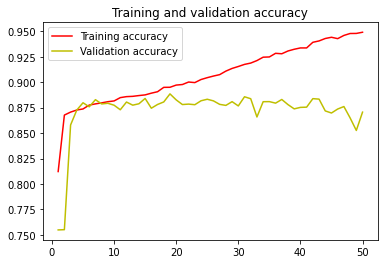

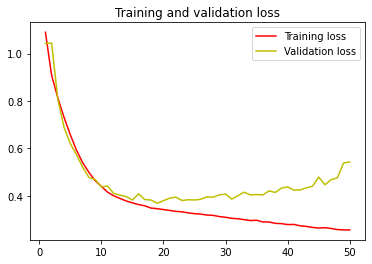

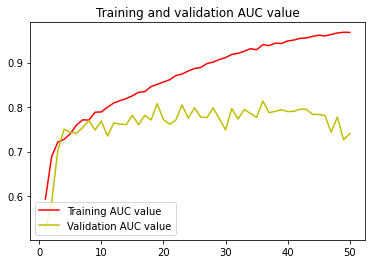

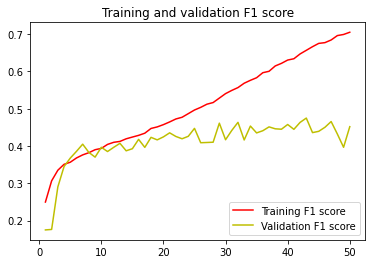

<Figure size 432x288 with 0 Axes>

In [141]:
f1_str = 'f1_at_k'
val_f1_str = 'val_'+f1_str

acc = history.history['accuracy_multilabel']
val_acc = history.history['val_accuracy_multilabel']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history[f1_str]
val_f1 = history.history[val_f1_str]

auc = history.history['auc_value']
val_auc = history.history['val_auc_value']

epochs_training = range(1, len(acc)+1)

plt.plot(epochs_training, acc, 'r', label='Training accuracy')
plt.plot(epochs_training, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.savefig(model_path+'accuracy.png')

plt.plot(epochs_training, loss, 'r', label='Training loss')
plt.plot(epochs_training, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.figure()
plt.savefig(model_path+'loss.png')

plt.plot(epochs_training, auc, 'r', label='Training AUC value')
plt.plot(epochs_training, val_auc, 'y', label='Validation AUC value')
plt.title('Training and validation AUC value')
plt.legend(loc=3)
plt.figure()
plt.savefig(model_path+'AUC.png')

plt.plot(epochs_training, f1, 'r', label='Training F1 score')
plt.plot(epochs_training, val_f1, 'y', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.legend(loc=4)
plt.figure()
plt.savefig(model_path+'f1 top 5.png')

plt.show()

#### Testing model

In [144]:
test_path = 'D:/ocular/ODIR-5K/ODIR-5K/Testing Images/'
testlist = os.listdir('D:/ocular/ODIR-5K/ODIR-5K/Testing Images/')
testlist.sort()

for i in range(0, len(testlist), 5):
    source = test_path+testlist[i]
    img = CLAHE(source, target_size, 20, (10,10))
    imgarray = tf.keras.preprocessing.image.img_to_array(img)
    imgarray = np.expand_dims(imgarray, axis=0)
    images = np.vstack([imgarray])/255
    classes = model.predict(images)
    classes = tf.cast(classes > 0.5, float)
    print(source, classes)

1/1 [==============================] - 0s 49ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 47ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1002_right.jpg tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 43ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1007_left.jpg tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 41ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1026_right.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 48ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1030_left.jpg tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 56ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1042_right.jpg tf.Tensor([[0. 

In [60]:
labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']
print(labels)

['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']


In [72]:
classesIndexes, classesFrequency = np.unique(y_true, return_counts=True)
print('classes indexes:' , classesIndexes)

classes indexes: [0 1 2 3 4 5 6 7]


In [73]:
# Making copy of array with True classes' indexes
y_predicted = np.copy(y_true)

In [76]:
c_m = confusion_matrix(y_true, y_predicted)
print(c_m)

[[11  0  0  1  0  0  0  0]
 [ 0  7  0  2  0  0  0  0]
 [ 1  0 13  0  3  0  0  0]
 [ 0  1  2 16  1  0  0  0]
 [ 0  1  1  2  8  0  0  0]
 [ 0  0  0  0  0  7  0  0]
 [ 0  0  0  0  1  0 11  0]
 [ 0  1  1  1  2  0  0  6]]


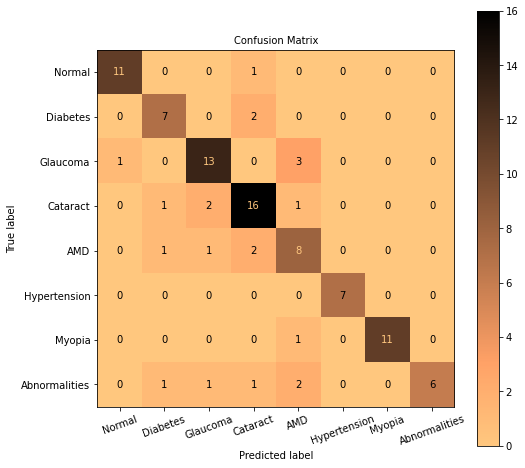

In [77]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = 10

display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)

display_c_m.plot(cmap='copper_r', xticks_rotation=20)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Confusion Matrix', fontsize=10)

plt.savefig('confusion_matrix.png', transparent=True, dpi=500)

plt.show()

In [78]:
# Showing the main classification metrics
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.70      0.78      0.74         9
           2       0.76      0.76      0.76        17
           3       0.73      0.80      0.76        20
           4       0.53      0.67      0.59        12
           5       1.00      1.00      1.00         7
           6       1.00      0.92      0.96        12
           7       1.00      0.55      0.71        11

    accuracy                           0.79       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.81      0.79      0.79       100



### MOBILENETV2

In [151]:
if ("use transfer learning" in use_model):

  if("using vgg19" in use_model):
    base_model= tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=target_size+shapeadd,)
    model_path = 'D:/ocular/ODIR-5K/ODIR-5K-VGG19-Multi-Label/'

  if("using mobilenetv2" in use_model):
    base_model= tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=target_size+shapeadd,)
    model_path = 'D:/ocular/ODIR-5K/ODIR-5K-MobileNetV2-Multi-Label/'

  for layer in base_model.layers:
    layer.trainable = False

  base_model.summary()

  conn = base_model.output

  conn = tf.keras.layers.Flatten()(conn)
  conn = tf.keras.layers.Dense(256, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  conn = tf.keras.layers.Dense(128, activation='relu', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              )(conn)

  conn = tf.keras.layers.Dropout(0.2)(conn)

  conn = tf.keras.layers.Dense(8, activation='sigmoid')(conn)

if (use_model == "using custom"):
  model_path = 'D:/ocular/ODIR-5K/ODIR-5K-MobileNetV2-Multi-Label/'

  inputs = tf.keras.Input(shape=target_size+shapeadd)
 
  # The first convolution
  conn = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
  conn = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2, 2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
 

  # The second convolution
  conn = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
 

  # The third convolution
  conn = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
 

  # The fourth convolution
  conn = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(conn)
  conn = tf.keras.layers.MaxPooling2D(2,2)(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)

  conn = tf.keras.layers.Flatten()(conn)
  conn = tf.keras.layers.Dense(256, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  conn = tf.keras.layers.Dense(128, activation='relu', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        )(conn)
  conn = tf.keras.layers.BatchNormalization()(conn)
  conn = tf.keras.layers.Dense(64, activation='relu', 
                        )(conn)
  conn = tf.keras.layers.Dense(8, activation='sigmoid')(conn)

In [152]:
use_training_model = False

checkpoint_path = model_path+'ODIR5K.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_save_weights = 'weight'
model_save_name_h5 = 'ODIR5K.h5'
model_save_name_tf = 'ODIR5K_TF'
model_save_name_js = 'ODIR5K_TFJS'

nEpoch = 25
BATCH_SIZE = 50
input_shape = target_size + shapeadd
learning_rate = 1e-4

loss = "binary_crossentropy"
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


if (os.path.isfile(model_path+model_save_name_h5) or os.path.exists(model_path+model_save_name_tf)) and use_training_model:

  if os.path.isfile(model_path+model_save_name_h5):
    print("using h5")
    model = tf.keras.models.load_model(model_path+model_save_name_h5)
  output = model.output
else:
  print("no using saved model")
  if (use_model == "using custom"):
    model = tf.keras.Model(inputs=inputs, outputs=conn)
  else:
    model = tf.keras.Model(base_model.input, conn)


model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[
                       accuracy_multilabel,
                       metricsAtTopK.f1_at_k,
                       AUC_value ])

no using saved model
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 230, 230, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 228, 228, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 226, 226, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 113, 113, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 113, 113, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 11

In [153]:
history = model.fit(
                    train_generator,
                    validation_data=validation_generator, 
                    epochs=50,
                    verbose=1,
                    callbacks=[callbackstop])                     

Epoch 1/50
197/197 [==============================] - 1028s 5s/step - loss: 1.0610 - accuracy_multilabel: 0.8300 - f1_at_k: 0.2804 - auc_value: 0.6292 - val_loss: 1.1056 - val_accuracy_multilabel: 0.7551 - val_f1_at_k: 0.2016 - val_auc_value: 0.5360
Epoch 2/50
197/197 [==============================] - 1009s 5s/step - loss: 0.8967 - accuracy_multilabel: 0.8697 - f1_at_k: 0.3232 - auc_value: 0.6968 - val_loss: 1.2382 - val_accuracy_multilabel: 0.7549 - val_f1_at_k: 0.1502 - val_auc_value: 0.6125
Epoch 3/50
197/197 [==============================] - 1007s 5s/step - loss: 0.8015 - accuracy_multilabel: 0.8737 - f1_at_k: 0.3465 - auc_value: 0.7209 - val_loss: 0.8118 - val_accuracy_multilabel: 0.8528 - val_f1_at_k: 0.3188 - val_auc_value: 0.6701
Epoch 4/50
197/197 [==============================] - 1005s 5s/step - loss: 0.7170 - accuracy_multilabel: 0.8756 - f1_at_k: 0.3595 - auc_value: 0.7401 - val_loss: 0.6738 - val_accuracy_multilabel: 0.8796 - val_f1_at_k: 0.3723 - val_auc_value: 0.7475


In [154]:
training_path = 'D:/ocular/ODIR-5K/ODIR-5K/Training Images/'
traininglist = os.listdir('D:/ocular/ODIR-5K/ODIR-5K/Training Images/')
output = tfa.metrics.MultiLabelConfusionMatrix(num_classes=8)
print("file name", "\t\t\t\t\t", "true label", "\t\t", "prediction label","\t", "accuracy score")
count_true = 0
count_half = 0
count_zero = 0
for i in range(0, len(test_filenames)):
  source = training_path+test_filenames[i]
 
  img = CLAHE(source, target_size, 20, (10,10))

  imgarray = tf.keras.preprocessing.image.img_to_array(img)
  imgarray = np.expand_dims(imgarray, axis=0)
  imgarray = imgarray/255.0
  images = np.vstack([imgarray])
  predict = model.predict(images)
 
  predict = predict.reshape(8)
 
  predict = tf.cast(predict >= 0.5, np.int32)
  y_true = tf.constant(test_labels[i], dtype=tf.int32)
  y_pred = tf.constant(predict.numpy(), dtype=tf.int32)
  accml = accuracy_multilabel(y_true, y_pred).numpy()
  count_true = count_true + 1 if accml == 1.0 else count_true
  count_half = count_half + 1 if 0.75 <= accml < 1 and 1 in predict.numpy().tolist() else count_half
  count_zero = count_zero + 1 if 1 not in predict.numpy().tolist() else count_zero
 
  print("---------------------------------------------------------------------------------------------------")
  print(source, "\t", test_labels[i], "\t", predict.numpy(), "\t", accml)

print('\n',"true :", count_true, "| half true :", count_half, "| zero :", count_zero)

file name 					 true label 		 prediction label 	 accuracy score
1/1 [==============================] - 1s 1s/step
---------------------------------------------------------------------------------------------------
D:/ocular/ODIR-5K/ODIR-5K/Training Images/1492_right.jpg 	 [0 0 1 0 0 0 0 0] 	 [1 0 0 0 0 0 0 0] 	 0.75
1/1 [==============================] - 0s 69ms/step
---------------------------------------------------------------------------------------------------
D:/ocular/ODIR-5K/ODIR-5K/Training Images/2926_right.jpg 	 [1 0 0 0 0 0 0 0] 	 [1 0 0 0 0 0 0 0] 	 1.0
1/1 [==============================] - 0s 77ms/step
---------------------------------------------------------------------------------------------------
D:/ocular/ODIR-5K/ODIR-5K/Training Images/1594_right.jpg 	 [0 0 0 0 0 0 1 0] 	 [0 0 0 0 0 0 1 0] 	 1.0
1/1 [==============================] - 0s 121ms/step
---------------------------------------------------------------------------------------------------
D:/ocular/ODIR-5K/O

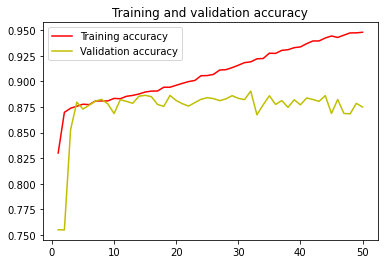

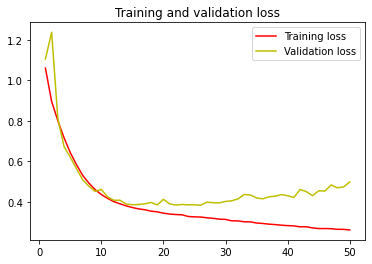

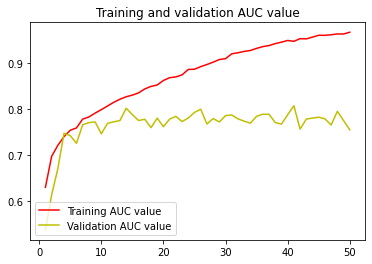

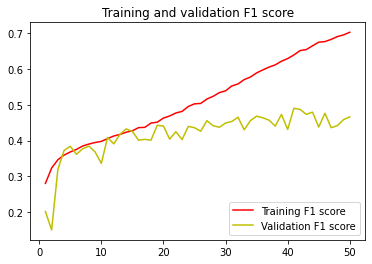

<Figure size 432x288 with 0 Axes>

In [156]:
f1_str = 'f1_at_k'
val_f1_str = 'val_'+f1_str

acc = history.history['accuracy_multilabel']
val_acc = history.history['val_accuracy_multilabel']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history[f1_str]
val_f1 = history.history[val_f1_str]

auc = history.history['auc_value']
val_auc = history.history['val_auc_value']

epochs_training = range(1, len(acc)+1)

plt.plot(epochs_training, acc, 'r', label='Training accuracy')
plt.plot(epochs_training, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.savefig(model_path+'accuracy.png')

plt.plot(epochs_training, loss, 'r', label='Training loss')
plt.plot(epochs_training, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.figure()
plt.savefig(model_path+'loss.png')

plt.plot(epochs_training, auc, 'r', label='Training AUC value')
plt.plot(epochs_training, val_auc, 'y', label='Validation AUC value')
plt.title('Training and validation AUC value')
plt.legend(loc=3)
plt.figure()
plt.savefig(model_path+'AUC.png')

plt.plot(epochs_training, f1, 'r', label='Training F1 score')
plt.plot(epochs_training, val_f1, 'y', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.legend(loc=4)
plt.figure()
plt.savefig(model_path+'f1 top 5.png')

plt.show()

In [157]:
test_path = 'D:/ocular/ODIR-5K/ODIR-5K/Testing Images/'
testlist = os.listdir('D:/ocular/ODIR-5K/ODIR-5K/Testing Images/')
testlist.sort()

for i in range(0, len(testlist), 5):
    source = test_path+testlist[i]
    img = CLAHE(source, target_size, 20, (10,10))
    imgarray = tf.keras.preprocessing.image.img_to_array(img)
    imgarray = np.expand_dims(imgarray, axis=0)
    images = np.vstack([imgarray])/255
    classes = model.predict(images)
    classes = tf.cast(classes > 0.5, float)
    print(source, classes)

1/1 [==============================] - 0s 78ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1000_left.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 76ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1002_right.jpg tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 83ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1007_left.jpg tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 71ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1026_right.jpg tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 91ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1030_left.jpg tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 8), dtype=float32)
1/1 [==============================] - 0s 77ms/step
D:/ocular/ODIR-5K/ODIR-5K/Testing Images/1042_right.jpg tf.Tensor([[0. 

In [9]:
labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']
print(labels)

['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']


In [10]:
classesIndexes, classesFrequency = np.unique(y_true, return_counts=True)
print('classes indexes:' , classesIndexes)

classes indexes: [0 1 2 3 4 5 6 7]


In [11]:
# Making copy of array with True classes' indexes
y_predicted = np.copy(y_true)

In [15]:
c_m = confusion_matrix(y_true, y_predicted)
print(c_m)

[[14  1  2  0  0  0  0  0]
 [ 0 13  0  0  0  0  1  0]
 [ 0  2  9  0  0  0  1  1]
 [ 0  1  1 10  0  1  0  0]
 [ 0  0  0  0  9  0  0  0]
 [ 0  1  0  0  0  8  1  2]
 [ 1  0  0  1  0  0  6  0]
 [ 1  1  0  1  0  0  0 11]]


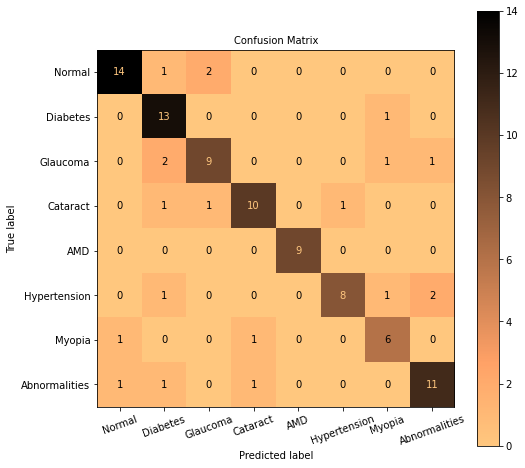

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = 10

display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)

display_c_m.plot(cmap='copper_r', xticks_rotation=20)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Confusion Matrix', fontsize=10)

plt.savefig('confusion_matrix.png', transparent=True, dpi=500)

plt.show()

In [19]:
# Showing the main classification metrics
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.68      0.93      0.79        14
           2       0.75      0.69      0.72        13
           3       0.83      0.77      0.80        13
           4       1.00      1.00      1.00         9
           5       0.89      0.67      0.76        12
           6       0.67      0.75      0.71         8
           7       0.79      0.79      0.79        14

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

